<h2>Загрузка данных</h2>

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet_v2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
def get_batches(path, image_size, classes, batch_size, shuffle=True):
    return ImageDataGenerator(preprocessing_function=efficientnet_v2.preprocess_input).flow_from_directory(
        directory=path,
        batch_size=batch_size,
        target_size=image_size,
        classes=classes,
        shuffle=shuffle)

In [3]:
train_path = 'dataset/train'
valid_path = 'dataset/valid'
test_path = 'dataset/test'
batch_size = 32
image_size = (300, 300)
classes = ['apple leaf miner', 'apple leaves healthy', 'begonia leaves healthy', 'coleus leaves healthy', 'grape leafhopper',
           'grape leaves healthy', 'iresine leaves healthy', 'kiwifruit leaves healthy', 'laurel leaf weevils', 'laurel leaves thrips', 'violet leaves healthy']

In [4]:
train_batches = get_batches(train_path, image_size, classes, batch_size)
valid_batches = get_batches(valid_path, image_size, classes, batch_size)
test_batches = get_batches(test_path, image_size, classes, batch_size, shuffle=False)

Found 1154 images belonging to 11 classes.
Found 245 images belonging to 11 classes.
Found 253 images belonging to 11 classes.


<h2>Создание модели</h2>

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [6]:
def get_layer_index(model, layer_name):
    layer_names = [layer.name for layer in model.layers]
    return layer_names.index(layer_name)

In [9]:
def create_model():
    initial_model = efficientnet_v2.EfficientNetV2B0(include_top=False, input_shape=(300,300,3))
    pooling_layer = GlobalAveragePooling2D(name='avg_pool')(initial_model.output)
    dropout_layer = Dropout(rate=0.5, name='top_dropout')(pooling_layer)
    #dense_layer = Dense(units=22, activation='relu', name='top_dense')(dropout_layer)
    output = Dense(units=11, activation='softmax', name='predictions')(dropout_layer)
    final_model = Model(inputs=initial_model.input, outputs=output)

    first_trainable_layer_index = get_layer_index(final_model, 'block6a_expand_conv')
    for index, layer in enumerate(final_model.layers):
        if index < first_trainable_layer_index:
            layer.trainable = False

    return final_model

In [10]:
model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 300, 300, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 300, 300, 3)  0          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [11]:
checkpoint_callback = ModelCheckpoint(
    filepath= 'checkpoints/1/saved-model-{epoch:02d}-{val_loss:.4f}.h5',
    verbose=1,
    monitor='val_loss')

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

<h2>Обучение модели</h2>

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
def plot_training(training_history):
    plt.figure(figsize=(12, 6))

    plt.plot(training_history.history['accuracy'])
    plt.plot(training_history.history['val_accuracy'])
    plt.xlabel('epoch', fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylabel('accuracy', fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('model accuracy', fontsize=15)
    plt.legend(['train', 'valid'], loc='lower right', fontsize=15)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(training_history.history['loss'])
    plt.plot(training_history.history['val_loss'])
    plt.xlabel('epoch', fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylabel('loss', fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('model loss', fontsize=15)
    plt.legend(['train', 'valid'], loc='upper right', fontsize=15)
    plt.show()

In [15]:
history = model.fit(
    x=train_batches,
    validation_data=valid_batches,
    epochs=30,
    verbose=2,
    callbacks=[checkpoint_callback])

Epoch 1/30

Epoch 1: saving model to checkpoints/1/saved-model-01-0.0990.h5
37/37 - 146s - loss: 0.5093 - accuracy: 0.8683 - val_loss: 0.0990 - val_accuracy: 0.9714 - 146s/epoch - 4s/step
Epoch 2/30

Epoch 2: saving model to checkpoints/1/saved-model-02-0.1506.h5
37/37 - 152s - loss: 0.0715 - accuracy: 0.9792 - val_loss: 0.1506 - val_accuracy: 0.9469 - 152s/epoch - 4s/step
Epoch 3/30

Epoch 3: saving model to checkpoints/1/saved-model-03-0.1388.h5
37/37 - 512s - loss: 0.0732 - accuracy: 0.9775 - val_loss: 0.1388 - val_accuracy: 0.9673 - 512s/epoch - 14s/step
Epoch 4/30

Epoch 4: saving model to checkpoints/1/saved-model-04-0.1697.h5
37/37 - 145s - loss: 0.0420 - accuracy: 0.9896 - val_loss: 0.1697 - val_accuracy: 0.9592 - 145s/epoch - 4s/step
Epoch 5/30

Epoch 5: saving model to checkpoints/1/saved-model-05-0.1776.h5
37/37 - 144s - loss: 0.0094 - accuracy: 0.9974 - val_loss: 0.1776 - val_accuracy: 0.9673 - 144s/epoch - 4s/step
Epoch 6/30

Epoch 6: saving model to checkpoints/1/saved-mo

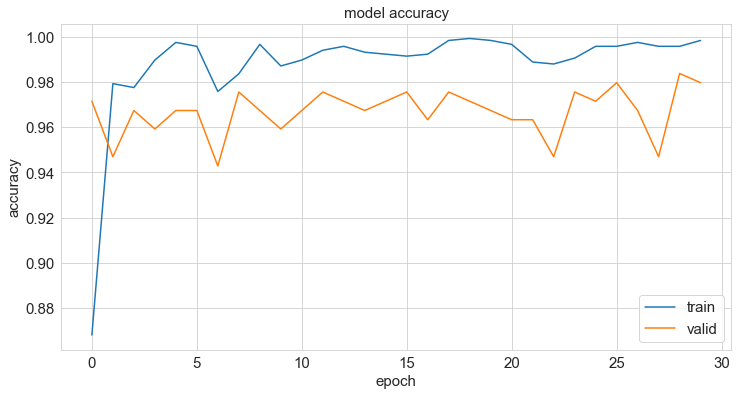

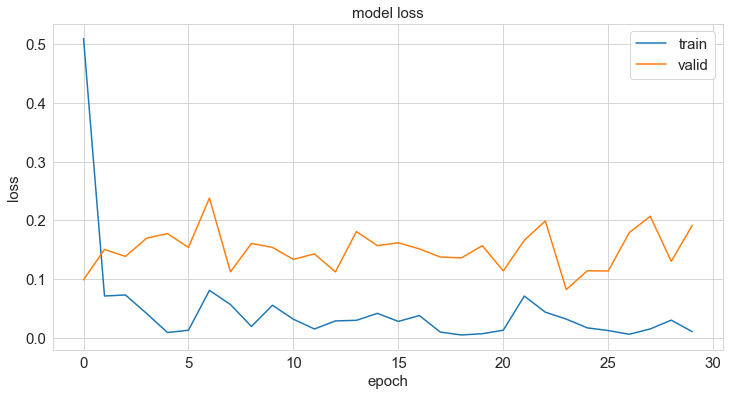

In [16]:
plot_training(history)

In [18]:
history_data = pd.DataFrame(history.history)
history_path = 'history2.csv'
with open(history_path, mode='w') as file:
    history_data.to_csv(file)

<h2>Результаты тестирования модели</h2>

In [19]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model

In [97]:
model = load_model('/Users/kirpro/Kirpro/Курсовая/checkpoints/saved-model-19-0.1243.h5')

In [98]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix\n'):
    plt.figure(figsize=(40, 40))

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n" for v1, v2 in zip(group_counts,group_percentages)]

    classes_number = np.array(classes).shape[0]
    labels = np.asarray(labels).reshape(classes_number, classes_number)

    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 25})

    ax.set_title(title, size=25);
    ax.set_xlabel('\nPredicted classes', size=25)
    ax.set_ylabel('Actual classes\n', size=25);

    ax.xaxis.set_ticklabels(classes, size=20)
    ax.yaxis.set_ticklabels(classes, size=20)

    plt.show()

In [99]:
predictions = model.predict(x=test_batches, verbose=0)
predicted_classes = np.argmax(predictions, axis=-1)

In [100]:
classes = ['Apple\nleaf miner', 'Healthy\napple leaves', 'Healthy\nbegonia leaves', 'Healthy\ncoleus leaves', 'Grape\nleafhopper', 'Healthy\ngrape   leaves ', 'Healthy\niresine leaves', 'Healthy\nkiwi leaves', 'Laurel\nleaf weevils', 'Laurel\nleaves thrips', 'Healthy\nviolet leaves']

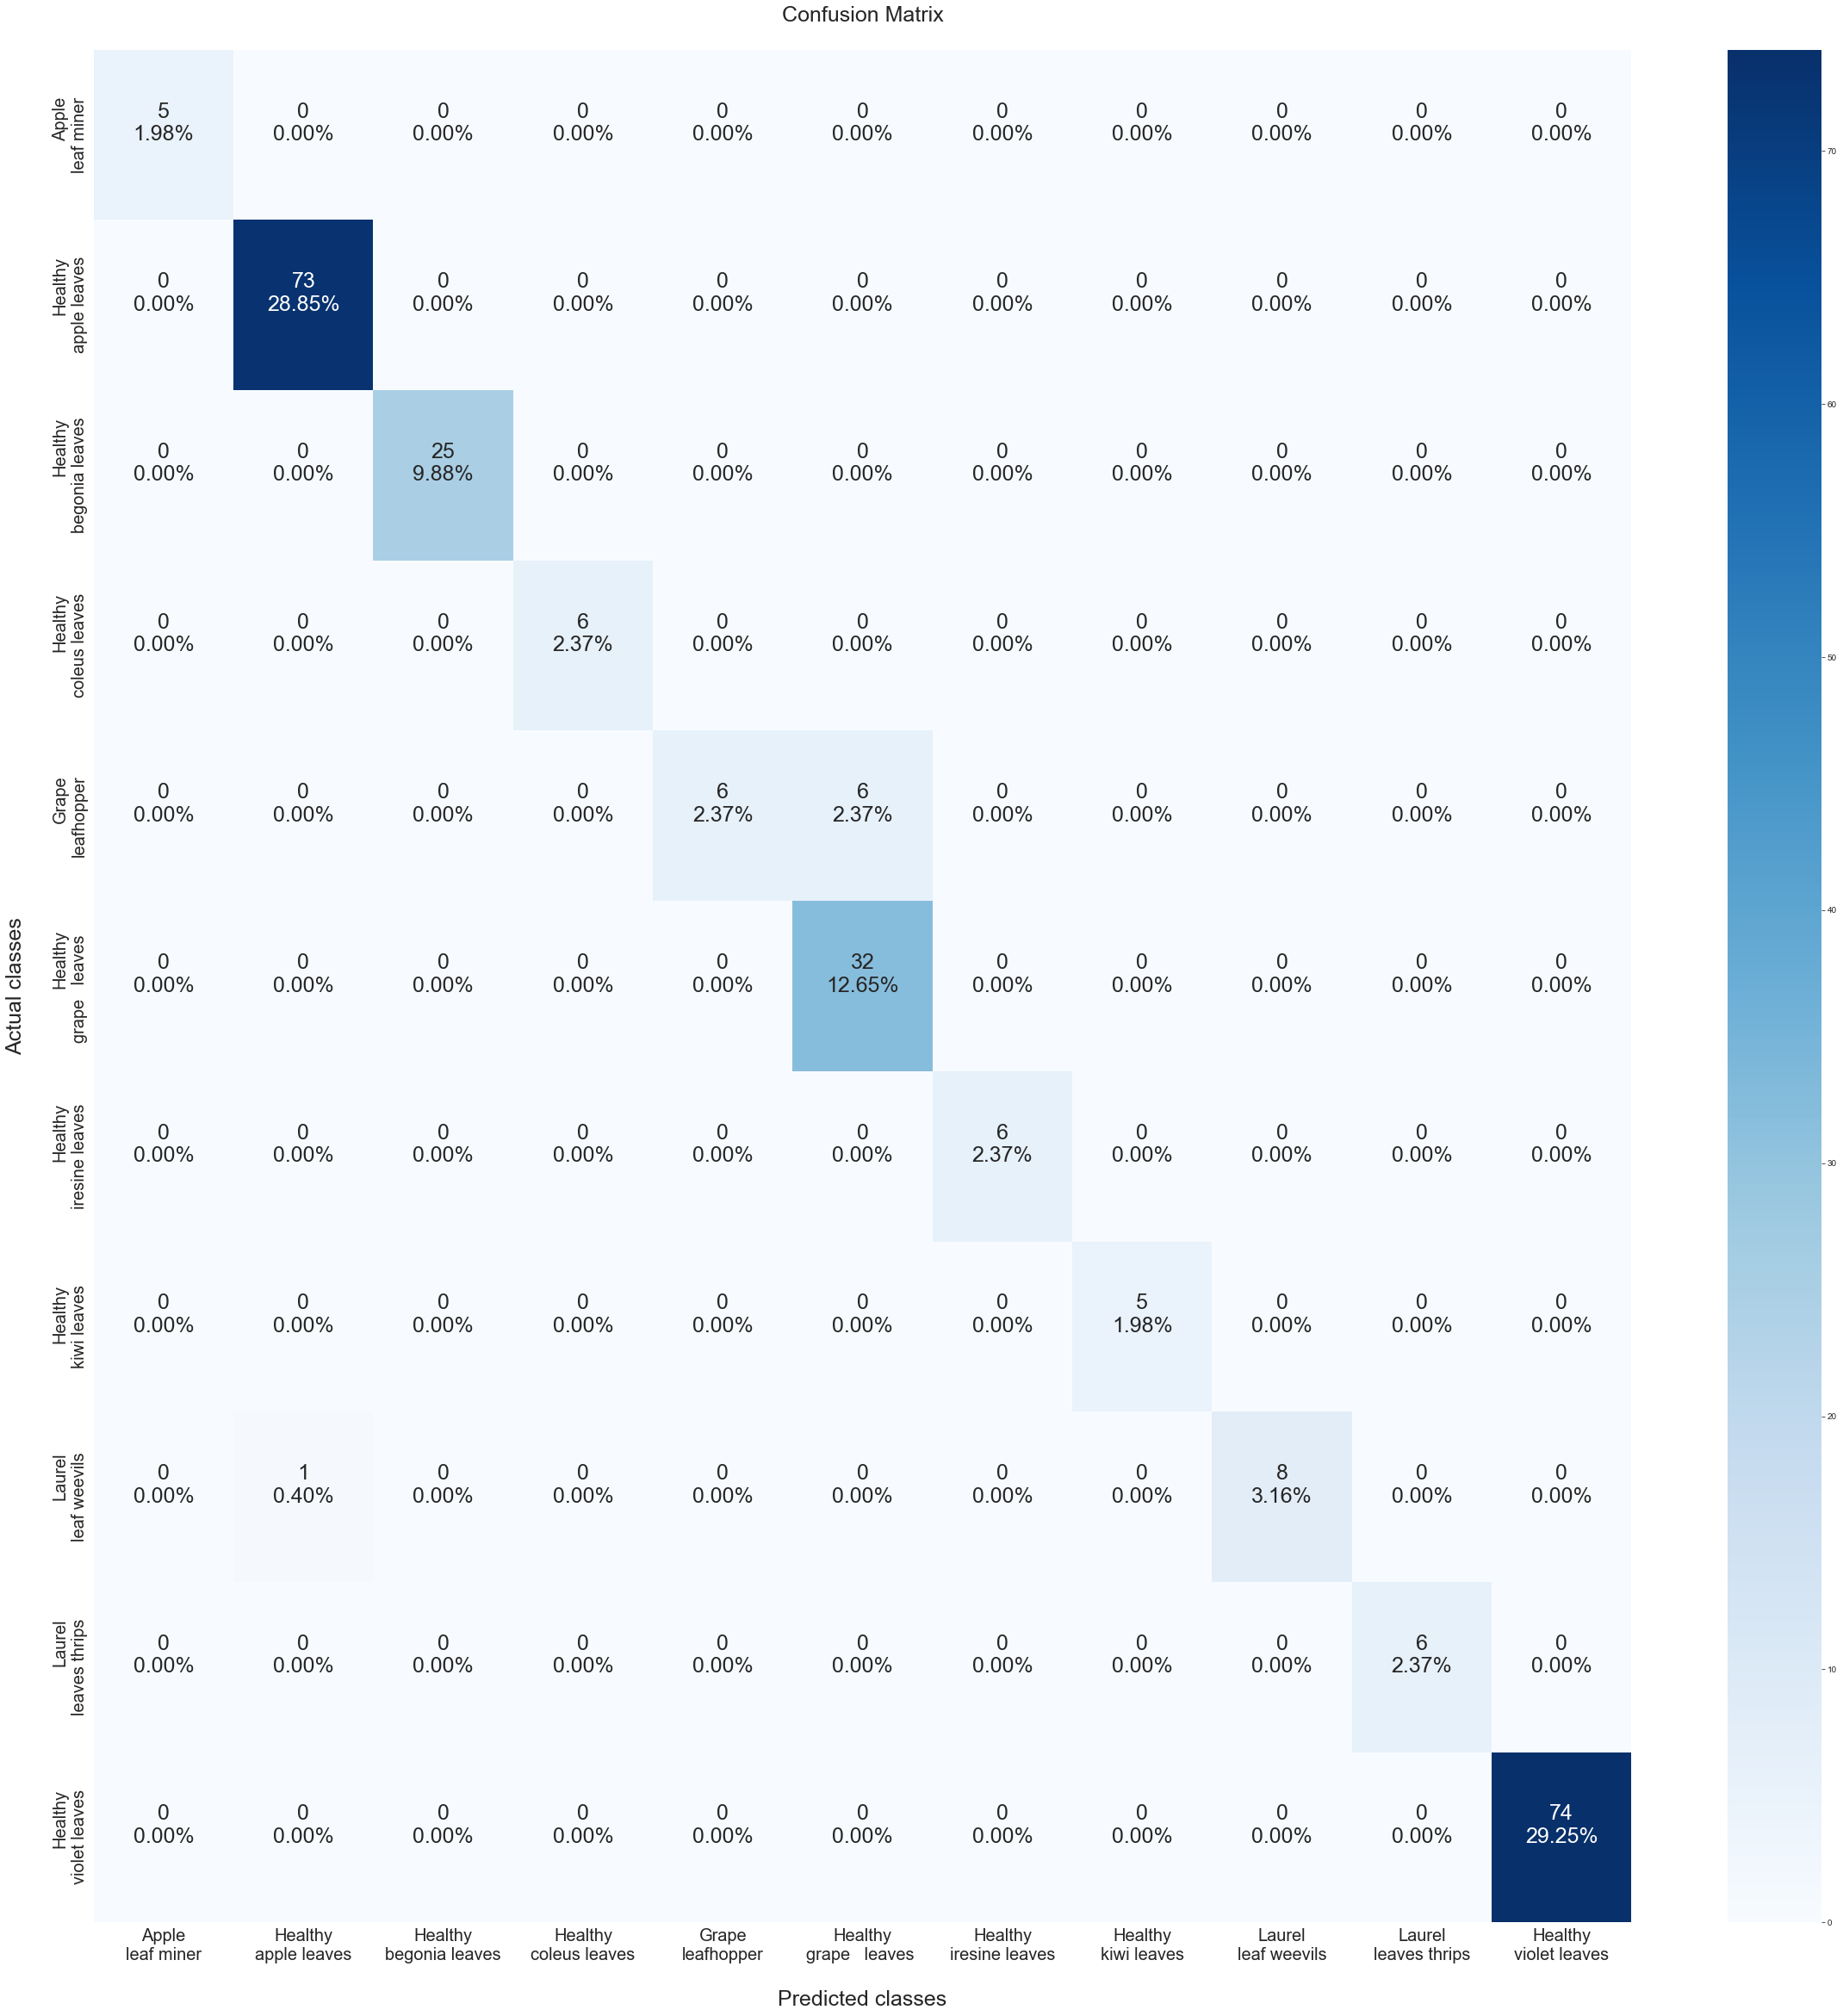

In [101]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=predicted_classes)
plot_confusion_matrix(cm, classes)

In [94]:
print(f'Accuracy is: {round(100 * accuracy_score(test_batches.classes, np.argmax(predictions, axis=-1)), 2)}%')

Accuracy is: 96.44%


<h2>Сохранение значений признаков</h2>

In [98]:
import csv

In [99]:
features_number = model.get_layer(name='top_dense').output.shape[1]

In [100]:
extractor = Model(
    inputs=model.inputs,
    outputs=model.get_layer(name='top_dense').output)

In [101]:
def extract_features(image):
    image = np.expand_dims(image, axis=0)
    return extractor(image)

In [102]:
def save_features(path, batches):
    with open(path, mode='w') as file:
        writer = csv.writer(file, delimiter=',')
        headers = np.append([f'feature {i}' for i in range(features_number)], 'class')
        writer.writerow(headers)
        for batch_index in range(len(batches)):
            batch = batches[batch_index]
            for image, labels in zip(batch[0], batch[1]):
                features = extract_features(image)
                label = int(np.argmax(labels))
                result = np.append(features, label)
                writer.writerow(result)

In [103]:
def save_predictions(path, predictions):
    data = pd.read_csv(path)
    for i in range(predictions.shape[1]):
            data[f'prediction {i}'] = predictions[:,i]
    data.to_csv(path)

In [104]:
train_path = 'train features.csv'
save_features(train_path, train_batches)

In [105]:
test_path = 'test features.csv'
save_features(test_path, test_batches)

In [106]:
save_predictions(test_path, predictions)